## 1. Setup & Imports

In [1]:
# Core
import os
import re
import string
import math
import numpy as np
import pandas as pd

# Modeling & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Plotting
import matplotlib.pyplot as plt

# Sentiment (use VADER if available, else fallback)
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except Exception:
    VADER_AVAILABLE = False

# Display options
pd.set_option('display.max_colwidth', 150)
print('VADER available:', VADER_AVAILABLE)


VADER available: False


## 2. Load & Inspect Data

In [2]:
df = pd.read_csv('blogs.csv')
print('Shape:', df.shape)
print('\nColumns:', list(df.columns))

Shape: (2000, 2)

Columns: ['Data', 'Labels']


In [3]:
# Try to standardize column names if needed
# Many times the file might have similar/aliased names; we try to map to Data/Labels.
col_map = {c.lower().strip(): c for c in df.columns}

In [4]:

# Find text column
text_col_candidates = [c for c in df.columns if c.lower().strip() in ['data','text','blog','content','post']]
label_col_candidates = [c for c in df.columns if c.lower().strip() in ['labels','label','category','categories','target']]

In [5]:
if not text_col_candidates:
    raise ValueError('Could not find text column. Expected a column like Data/Text/Content/Post. Found: ' + str(list(df.columns)))

if not label_col_candidates:
    raise ValueError('Could not find label column. Expected a column like Labels/Label/Category/Target. Found: ' + str(list(df.columns)))

TEXT_COL = text_col_candidates[0]
LABEL_COL = label_col_candidates[0]

In [6]:

print(f'Using TEXT_COL = {TEXT_COL!r}, LABEL_COL = {LABEL_COL!r}')

# Basic preview
display(df[[TEXT_COL, LABEL_COL]].head())

# Drop rows with missing text or labels
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# Remove duplicates
df = df.drop_duplicates(subset=[TEXT_COL, LABEL_COL])

print('After cleaning - Shape:', df.shape)
df.head()


Using TEXT_COL = 'Data', LABEL_COL = 'Labels'


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!aga...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mp...,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!olivea!hal.com!decwrl!usenet.coe.montana.edu!news.u.washington.edu!carson....,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!venice...,alt.atheism
4,"Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53485 talk.religion.misc:83858 talk.origins:40979\nNewsgroups: alt.atheism,talk.religion.misc,talk.ori...",alt.atheism


After cleaning - Shape: (2000, 2)


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!aga...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mp...,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!olivea!hal.com!decwrl!usenet.coe.montana.edu!news.u.washington.edu!carson....,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!venice...,alt.atheism
4,"Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53485 talk.religion.misc:83858 talk.origins:40979\nNewsgroups: alt.atheism,talk.religion.misc,talk.ori...",alt.atheism


## 3. Exploratory Data Analysis (EDA)

In [7]:
# Class distribution
print('Label distribution:')
display(df[LABEL_COL].value_counts())

Label distribution:


Labels
alt.atheism                 100
comp.graphics               100
talk.politics.misc          100
talk.politics.mideast       100
talk.politics.guns          100
soc.religion.christian      100
sci.space                   100
sci.med                     100
sci.electronics             100
sci.crypt                   100
rec.sport.hockey            100
rec.sport.baseball          100
rec.motorcycles             100
rec.autos                   100
misc.forsale                100
comp.windows.x              100
comp.sys.mac.hardware       100
comp.sys.ibm.pc.hardware    100
comp.os.ms-windows.misc     100
talk.religion.misc          100
Name: count, dtype: int64

In [8]:
# Text length stats
df['text_len'] = df[TEXT_COL].astype(str).apply(lambda s: len(s.split()))
print('\nText length (words) summary:')
display(df['text_len'].describe())


Text length (words) summary:


count     2000.000000
mean       314.166000
std        539.210333
min         31.000000
25%        127.000000
50%        194.000000
75%        319.000000
max      10384.000000
Name: text_len, dtype: float64

In [9]:

# Show some examples per class
print('\nSample texts per class:')
for lab in df[LABEL_COL].value_counts().index[:5]:
    ex = df[df[LABEL_COL]==lab][TEXT_COL].iloc[0]
    print(f'\n== {lab} ==')
    print(ex[:500])



Sample texts per class:

== alt.atheism ==
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!agate!doc.ic.ac.uk!uknet!mcsun!Germany.EU.net!thoth.mchp.sni.de!horus.ap.mchp.sni.de!D012S658!frank
From: frank@D012S658.uucp (Frank O'Dwyer)
Newsgroups: alt.atheism
Subject: Re: islamic genocide
Date: 23 Apr 1993 23:51:47 GMT
Organization: Siemens-Nixdorf AG
Lines: 110
Distribution: world
Message-ID: <1r9vej$5k5@horus.ap.mchp.sni.de>
References: <1r4o8a$

== comp.graphics ==
Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!gatech!purdue!mentor.cc.purdue.edu!news
From: ab@nova.cc.purdue.edu (Allen B)
Subject: Re: thining algorithm
Message-ID: <C5Fstu.6wz@mentor.cc.purdue.edu>
Sender: news@mentor.cc.purdue.edu (USENET News)
Organization: Purdue University
References: 

## 4. Preprocessing & Feature Extraction (TF-IDF)

In [10]:

def build_pipeline(ngram_range=(1,2), max_features=50000):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(
            lowercase=True,
            stop_words='english',   # set to None if not English
            ngram_range=ngram_range,
            max_features=max_features
        )),
        ('nb', MultinomialNB())
    ])
    return pipe


## 5. Train/Test Split & Model Training

In [11]:

X = df[TEXT_COL].astype(str).values
y = df[LABEL_COL].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:


model = build_pipeline()
model.fit(X_train, y_train)




,steps,"[('tfidf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [13]:
y_pred = model.predict(X_test)
print('Done training.')

Done training.


## 6. Evaluation: Accuracy, Precision, Recall, F1

In [14]:
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'Precision (weighted): {prec:.4f}')
print(f'Recall (weighted): {rec:.4f}')
print(f'F1-score (weighted): {f1:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.8450
Precision (weighted): 0.8523
Recall (weighted): 0.8450
F1-score (weighted): 0.8429

Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.65      0.68        20
           comp.graphics       0.81      0.85      0.83        20
 comp.os.ms-windows.misc       0.91      1.00      0.95        20
comp.sys.ibm.pc.hardware       0.79      0.95      0.86        20
   comp.sys.mac.hardware       0.85      0.85      0.85        20
          comp.windows.x       0.93      0.70      0.80        20
            misc.forsale       0.78      0.90      0.84        20
               rec.autos       0.83      0.95      0.88        20
         rec.motorcycles       0.93      0.70      0.80        20
      rec.sport.baseball       0.90      0.95      0.93        20
        rec.sport.hockey       0.95      1.00      0.98        20
               sci.crypt       0.91      1.00      0.95        20
         sci.elec

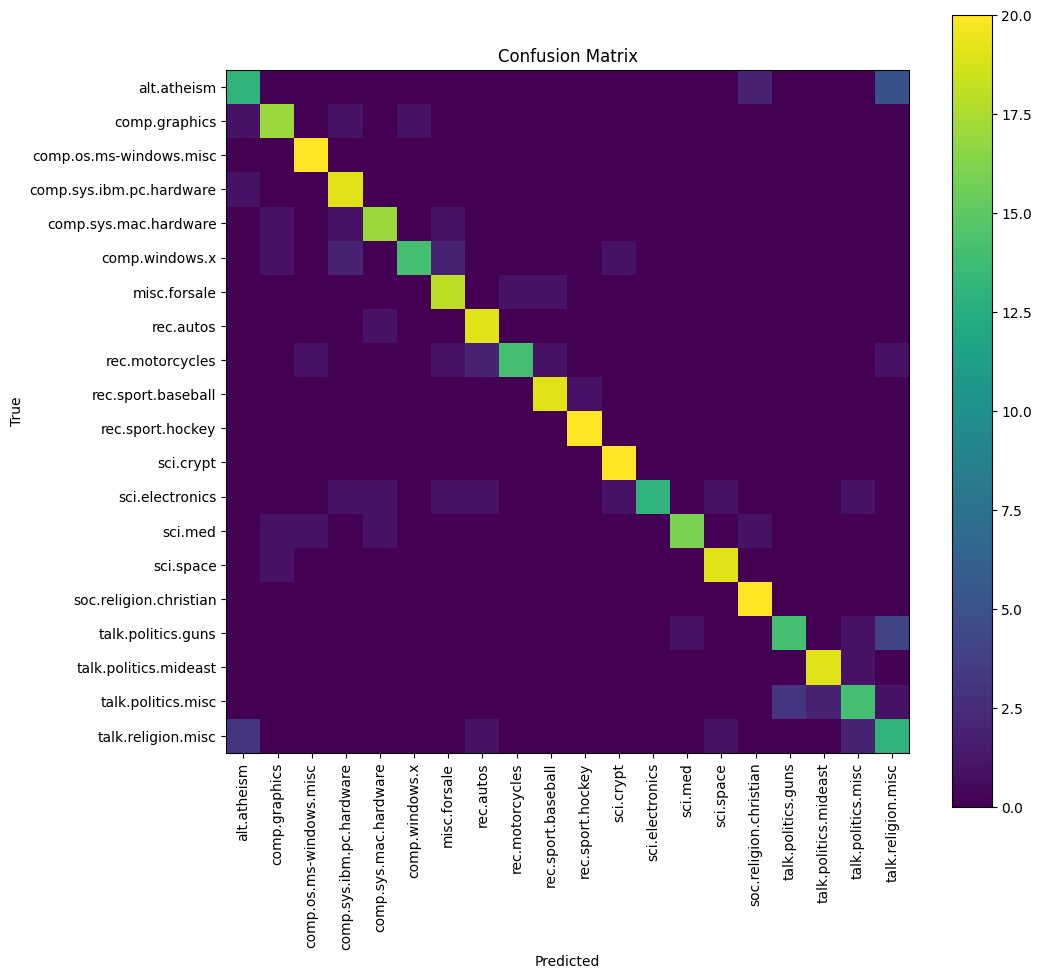

In [15]:

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred, labels=sorted(pd.unique(y)))
fig = plt.figure(figsize=(11,10))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(sorted(pd.unique(y)))), sorted(pd.unique(y)), rotation=90)
plt.yticks(range(len(sorted(pd.unique(y)))), sorted(pd.unique(y)))
plt.colorbar()
plt.tight_layout()
plt.show()


## 7. Sentiment Analysis

In [16]:
def sentiment_vader(texts):
    analyzer = SentimentIntensityAnalyzer()
    scores = []
    for t in texts:
        ss = analyzer.polarity_scores(t if isinstance(t, str) else str(t))
        # Compound score: > 0.05 => pos, < -0.05 => neg, else neutral
        comp = ss['compound']
        if comp > 0.05:
            label = 'positive'
        elif comp < -0.05:
            label = 'negative'
        else:
            label = 'neutral'
        scores.append({'compound': comp, 'sentiment': label})
    return pd.DataFrame(scores)

In [17]:
# Fallback simple lexicon if VADER not available
POS_WORDS = set(['good','great','excellent','amazing','love','loved','like','liked','happy','wonderful','best','fantastic','awesome','enjoy','enjoyed','positive'])
NEG_WORDS = set(['bad','terrible','awful','hate','hated','dislike','sad','worst','poor','horrible','angry','annoying','negative','disappointed'])


In [18]:
def sentiment_simple(texts):
    rows = []
    for t in texts:
        s = str(t).lower()
        pos = sum(w in s for w in POS_WORDS)
        neg = sum(w in s for w in NEG_WORDS)
        comp = (pos - neg) / (pos + neg + 1e-6)
        if comp > 0.05:
            label = 'positive'
        elif comp < -0.05:
            label = 'negative'
        else:
            label = 'neutral'
        rows.append({'compound': float(comp), 'sentiment': label})
    return pd.DataFrame(rows)

In [19]:
if VADER_AVAILABLE:
    sent_df = sentiment_vader(df[TEXT_COL].astype(str).tolist())
else:
    sent_df = sentiment_simple(df[TEXT_COL].astype(str).tolist())

df_sent = pd.concat([df[[TEXT_COL, LABEL_COL]].reset_index(drop=True), sent_df], axis=1)
print('Sentiment head:')
display(df_sent.head())

Sentiment head:


,Data,Labels,compound,sentiment
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!aga...,alt.atheism,0.000000,neutral
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mp...,alt.atheism,0.999999,positive
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!olivea!hal.com!decwrl!usenet.coe.montana.edu!news.u.washington.edu!carson....,alt.atheism,0.333333,positive
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!venice...,alt.atheism,0.142857,positive
4,"Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53485 talk.religion.misc:83858 talk.origins:40979\nNewsgroups: alt.atheism,talk.religion.misc,talk.ori...",alt.atheism,0.000000,neutral


In [20]:
# Save sentiments
OUT_SENT_CSV = 'blogs_sentiments.csv'
df_sent.to_csv(OUT_SENT_CSV, index=False)
print('Saved:', OUT_SENT_CSV)

Saved: blogs_sentiments.csv


In [21]:
# Category-wise sentiment distribution
cat_sent = (df_sent
            .groupby([LABEL_COL, 'sentiment'])
            .size()
            .reset_index(name='count'))

print('\nCategory-wise sentiment counts:')
display(cat_sent.head(20))


Category-wise sentiment counts:


,Labels,sentiment,count
0,alt.atheism,negative,12
1,alt.atheism,neutral,42
2,alt.atheism,positive,46
3,comp.graphics,negative,4
4,comp.graphics,neutral,46
5,comp.graphics,positive,50
6,comp.os.ms-windows.misc,negative,6
7,comp.os.ms-windows.misc,neutral,48
8,comp.os.ms-windows.misc,positive,46
9,comp.sys.ibm.pc.hardware,negative,3


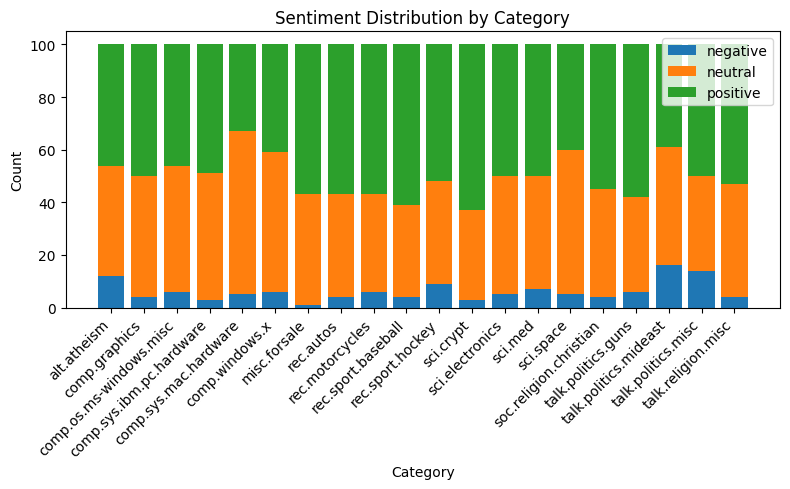

In [22]:
# Plot category-wise sentiment distribution (stacked bar per category)
pivot = cat_sent.pivot(index=LABEL_COL, columns='sentiment', values='count').fillna(0)
pivot = pivot[['negative','neutral','positive']] if set(['negative','neutral','positive']).issubset(pivot.columns) else pivot

fig = plt.figure(figsize=(8,5))
bottom = np.zeros(len(pivot))
for col in pivot.columns:
    plt.bar(pivot.index.astype(str), pivot[col].values, bottom=bottom, label=col)
    bottom = bottom + pivot[col].values
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


## 8. (Optional) Save Trained Model & Vectorizer

In [23]:
# If you want to persist the trained pipeline:
import joblib
MODEL_PATH = 'naive_bayes_tfidf_pipeline.joblib'
joblib.dump(model, MODEL_PATH)
print('Saved model to:', MODEL_PATH)


Saved model to: naive_bayes_tfidf_pipeline.joblib


## 9. Notes & Next Steps
- Tune `TfidfVectorizer` (e.g., `min_df`, `max_df`, `ngram_range`) and `alpha` for `MultinomialNB` using cross-validation.
- Consider class imbalance (e.g., `class_weight` strategies or resampling).
- For sentiment, if possible, install and use `vaderSentiment` for better results (already auto-detected if installed).
- Ensure your dataset language aligns with the stop-word list (set `stop_words=None` if not English).
